In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SimpleRNN

In [ ]:
train_df = pd.read_csv('Train.csv')
valid_df = pd.read_csv('Valid.csv')
test_df  = pd.read_csv('Test.csv')

print("Train DataFrame shape:", train_df.shape)
print("Valid DataFrame shape:", valid_df.shape)
print("Test DataFrame shape:", test_df.shape)

Train DataFrame shape: (40000, 2)
Valid DataFrame shape: (5000, 2)
Test DataFrame shape: (5000, 2)


Train Data Sample:
                                                text  label
0  I grew up (b. 1965) watching and loving the Th...      0
1  When I put this movie in my DVD player, and sa...      0
2  Why do people who do not know what a particula...      0
3  Even though I have great interest in Biblical ...      0
4  Im a die hard Dads Army fan and nothing will e...      1

Review Length Statistics in Train Data:
count    40000.000000
mean       231.339250
std        171.194123
min          4.000000
25%        126.000000
50%        173.000000
75%        282.000000
max       2470.000000
Name: review_length, dtype: float64


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


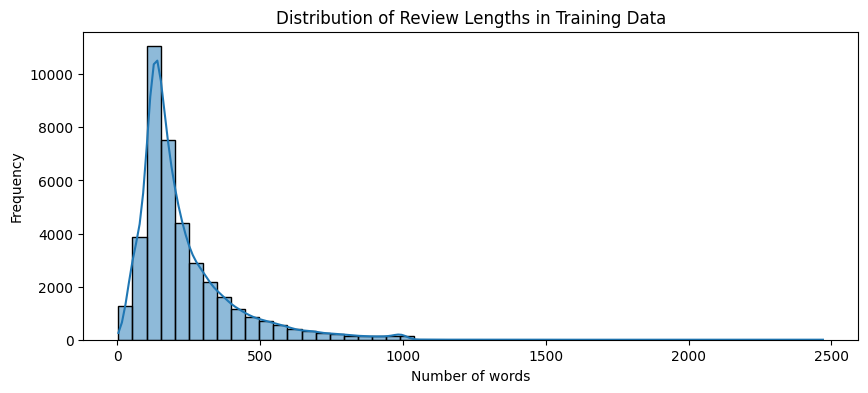


Label Distribution in Train Data:
label
0    20019
1    19981
Name: count, dtype: int64


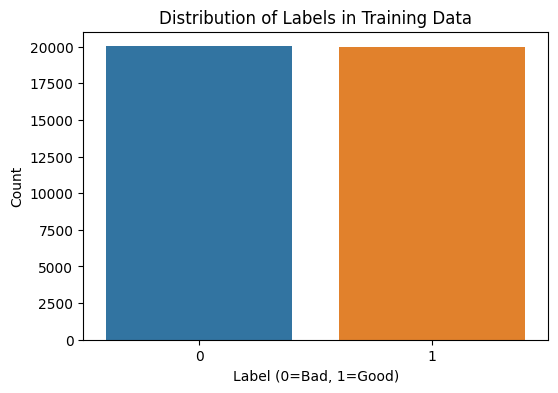

In [8]:
# Show a few rows of the training data
print("Train Data Sample:")
print(train_df.head())

# Check basic statistics for text lengths
train_df['review_length'] = train_df['text'].apply(lambda x: len(x.split()))
print("\nReview Length Statistics in Train Data:")
print(train_df['review_length'].describe())

# Plot the distribution of review lengths
plt.figure(figsize=(10, 4))
sns.histplot(train_df['review_length'], bins=50, kde=True)
plt.title("Distribution of Review Lengths in Training Data")
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.show()

# Check the label distribution
print("\nLabel Distribution in Train Data:")
print(train_df['label'].value_counts())

plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=train_df)
plt.title("Distribution of Labels in Training Data")
plt.xlabel("Label (0=Bad, 1=Good)")
plt.ylabel("Count")
plt.show()

In [9]:
# Extract text and labels directly
X_train = train_df['text']
y_train = train_df['label']

X_valid = valid_df['text']
y_valid = valid_df['label']

X_test = test_df['text']
y_test = test_df['label']

In [10]:
# Set parameters for tokenization and padding
max_vocab = 10000   # maximum vocabulary size
max_length = 200    # maximum review length (in words)

tokenizer = Tokenizer(num_words=max_vocab, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Convert texts to sequences
train_sequences = tokenizer.texts_to_sequences(X_train)
valid_sequences = tokenizer.texts_to_sequences(X_valid)
test_sequences  = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure uniform length
X_train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
X_valid_padded = pad_sequences(valid_sequences, maxlen=max_length, padding='post', truncating='post')
X_test_padded  = pad_sequences(test_sequences,  maxlen=max_length, padding='post', truncating='post')

In [16]:
embedding_dim = 64  # Dimension for the embedding vector

model = Sequential([
    Embedding(input_dim=max_vocab, output_dim=embedding_dim, input_length=max_length),
    
    # First recurrent layer returns sequences to feed into the next RNN layer
    SimpleRNN(64, return_sequences=True),
    Dropout(0.05),
    
    # Second recurrent layer
    SimpleRNN(32, return_sequences=False),
    Dropout(0.05),
    
    # A Dense layer to further process the learned representations
    Dense(64, activation='relu'),
    
    # Output layer for binary classification
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_3 (SimpleRNN)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_4 (SimpleRNN)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [17]:
epochs = 10
batch_size = 64

history = model.fit(
    X_train_padded, y_train, 
    epochs=epochs, 
    batch_size=batch_size, 
    validation_data=(X_valid_padded, y_valid)
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 27s 37ms/step - accuracy: 0.4992 - loss: 0.6977 - val_accuracy: 0.4960 - val_loss: 0.6971
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - accuracy: 0.5052 - loss: 0.6960 - val_accuracy: 0.5116 - val_loss: 0.6928
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - accuracy: 0.5041 - loss: 0.6949 - val_accuracy: 0.5058 - val_loss: 0.7029
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - accuracy: 0.4964 - loss: 0.6950 - val_accuracy: 0.4972 - val_loss: 0.6976
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - accuracy: 0.5029 - loss: 0.6944 - val_accuracy: 0.4972 - val_loss: 0.6937
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - accuracy: 0.4980 - loss: 0.6937 - val_accuracy: 0.4972 - val_loss: 0.6943
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - accuracy: 0.5005 - loss: 0.6937 - val_accuracy: 0.5042 - val_loss: 0.6933
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - accuracy: 0.4972 - loss: 0.6938 - 

In [18]:
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.4890 - loss: 0.7091
Test Accuracy: 0.5040


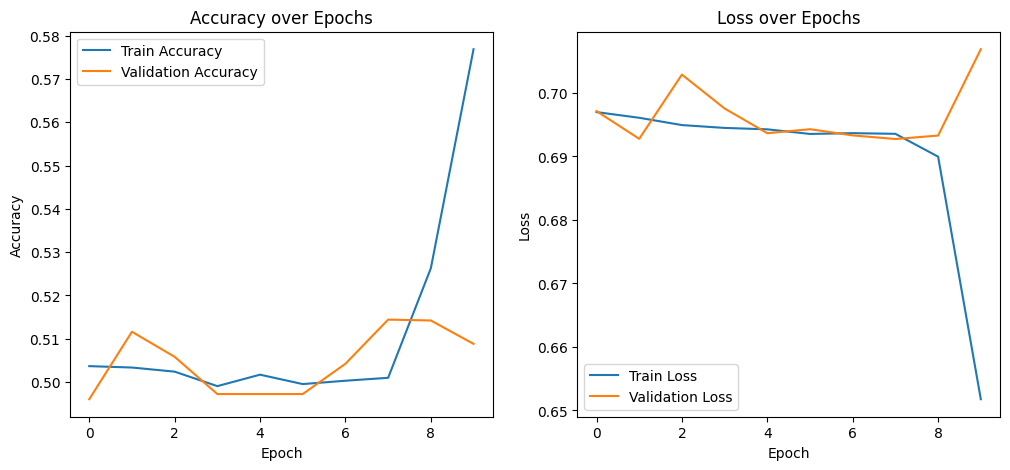

In [19]:
plt.figure(figsize=(12,5))

# Plot accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()

# Plot loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

plt.show()

In [22]:
user_review = "It wasn't the best movie"

# Preprocess the review: tokenize and pad the sequence
review_sequence = tokenizer.texts_to_sequences([user_review])
review_padded = pad_sequences(review_sequence, maxlen=max_length, padding='post', truncating='post')

# Make a prediction using the trained model
prediction = model.predict(review_padded)
predicted_prob = prediction[0][0]

if predicted_prob >= 0.5:
    sentiment = "Positive"
    confidence = predicted_prob
else:
    sentiment = "Negative"
    confidence = 1 - predicted_prob
print("Review:")
print(user_review)
print("\nPredicted Sentiment:", sentiment, f"(Confidence: {confidence:.4f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Review:
It wasn't the best movie

Predicted Sentiment: Negative (Confidence: 0.5089)


# using LSTM

In [23]:
embedding_dim = 64  # Dimension for the embedding vector

model = Sequential([
    Embedding(input_dim=max_vocab, output_dim=embedding_dim, input_length=max_length),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [24]:
epochs = 10
batch_size = 64

history = model.fit(
    X_train_padded, y_train, 
    epochs=epochs, 
    batch_size=batch_size, 
    validation_data=(X_valid_padded, y_valid)
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.5420 - loss: 0.6841 - val_accuracy: 0.5786 - val_loss: 0.7318
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.6009 - loss: 0.6701 - val_accuracy: 0.6386 - val_loss: 0.6968
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.5941 - loss: 0.6594 - val_accuracy: 0.6166 - val_loss: 0.6356
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.6151 - loss: 0.6535 - val_accuracy: 0.6442 - val_loss: 0.6444
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.6210 - loss: 0.6465 - val_accuracy: 0.5344 - val_loss: 0.6904
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.5448 - loss: 0.6861 - val_accuracy: 0.7810 - val_loss: 0.6101
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.5830 - loss: 0.6720 - val_accuracy: 0.6582 - val_loss: 0.6247
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.7138 - loss: 0.5711 - val_acc

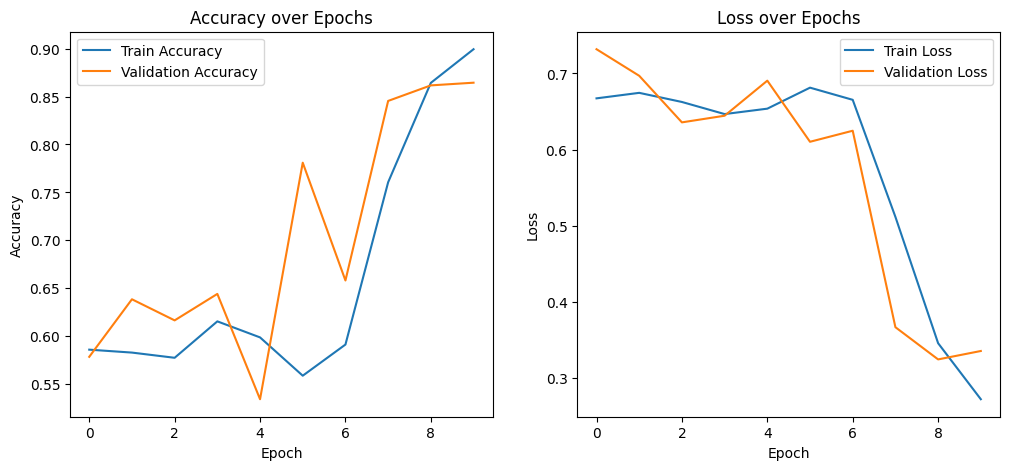

In [25]:
plt.figure(figsize=(12,5))

# Plot accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()

# Plot loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

plt.show()